# Inventory dynamics problem with stochastic demand

In this exercise you’ll continue developing the inventory model from the lecture
and extend it to the infinite horizon case with stochastic demand.

### Specification of stochastic demand

Assume that $ d(t) $ is stochastic and follows geometric distribution with the support
$ k \in \{0,1,2,\dots\} $  and corresponding probabilities $ P(k)=(1-p)^k p $, where $ p $ is a fixed parameter.

### Tasks

1. Study the started code below
1. Code up the Bellman equation for the problem by filling out the gaps
1. Implement VFI solver for the infinite horizon stochastic inventory problem by filling the gaps
1. Run several tests of the solver using parameter values you see fit  
1. Study the plots to illustrate convergence of the value and the policy functions to the solution

In [1]:
# Pre - code for completion as part of the task

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

class inventory_model:
    '''Small class to hold model fundamentals and its solution'''

    def __init__(self,label='noname',
                  max_inventory=10,  # upper bound on the state space
                  c = 3.2,            # fixed cost of order
                  p = 2.5,           # profit per unit of good
                  r = 0.5,           # storage cost per unit of good
                  β = 0.95,          # discount factor
                  dp = 0.5,          # parameter in geometric distribution of demand
                  demand = 4         # fixed demand
                  ):
        '''Create model with default parameters'''
        self.label=label # label for the model instance
        self.c, self.p, self.r, self.β, self.dp= c, p, r, β, dp
        self.demand = demand
        # created dependent attributes (it would be better to have them updated when underlying parameters change)
        self.n = max_inventory+1    # number of inventory levels
        self.upper = max_inventory  # upper boundary on inventory
        self.x = np.arange(self.n)  # all possible values of inventory and demand (state space) 

    def __repr__(self):
        '''String representation of the model'''
        return 'Inventory model labeled "{}"\nParamters (c,p,r,β) = ({},{},{},{})\nDemand={}\nUpper bound on inventory {}' \
                .format (self.label,self.c,self.p,self.r,self.β,self.demand,self.upper)

    def sales(self,x,d):
        '''Sales in given period'''
        return np.minimum(x,d)

    def next_x(self,x,d,q):
        '''Inventory to be stored, becomes next period state'''
        return x - self.sales(x,d) + q

    def profit(self,x,d,q):
        '''Profit in given period'''
        return self.p * self.sales(x,d) - self.r * self.next_x(x,d,q) - self.c * (q>0)
    
    def demand_pr(self,plot=False):
        '''Computes stochastic demand probs'''
        k = np.arange(self.n)  # all possible values of demand
        pr = (1-self.dp)**k *self.dp
        pr[-1] = 1 - pr[:-1].sum()  # update last prob to ensure sum=1
        if plot:
            plt.step(self.x,pr,where='mid')
            plt.title('Distribution of demand')
            plt.show()
        return pr
    
def bellman(m,v0):
    '''Bellman equation for inventory model
        Inputs: model object
                next period value function
    '''
    # insert your code in #***#
    # create the grid of choices (same as x), column-vector
    q = m.x[:,np.newaxis]
    # compute current period profit (relying on numpy broadcasting to get the matrix with choices in rows)
    p = m.profit(m.x, m.demand, q)
    # indexes for next period value with extrapolation using last value
    i = np.minimum(m.next_x(m.x, m.demand, q), m.upper)
    # compute the Bellman maximand
    vm = p + m.β * v0[i] # (max_inventory,max_inventory)
    # find max and argmax
    #***#   # maximum in every column
    v1 = np.amax(vm, axis=0) # (max_inventory,)

    #***# # arg-maximum in every column = order volume
    q1 = np.argmax(vm, axis=1) # (max_inventory,)
    return v1, q1

def solver_backwards_induction(m,T=10,verbose=False):
    '''Backwards induction solver for the finite horizon case'''
    # solution is time dependent
    m.value  = np.zeros((m.n,T))
    m.policy = np.zeros((m.n,T))
    # main DP loop (from T to 1)
    for t in range(T,0,-1):
        if verbose:
            print('Time period %d\n'%t)
        j = t-1 # index of value and policy functions for period t
        if t==T:
            # terminal period: ordering zero is optimal
            m.value[:,j] = m.profit(m.x,m.demand,np.zeros(m.n))
            m.policy[:,j] = np.zeros(m.n)
        else:
            # all other periods
            m.value[:,j], m.policy[:,j] = bellman(m,m.value[:,j+1]) # next period to Bellman
        if verbose:
            print(m.value,'\n')
    # return model with updated value and policy functions
    return m

def plot_solution(model):
    plt.step(model.x,model.value)
    plt.legend([f'{i+1}' for i in range(model.value.shape[1])])
    plt.title('Value function')
    plt.show()
    plt.step(model.x,model.policy)
    plt.legend([f'{i+1}' for i in range(model.policy.shape[1])])
    plt.title('Policy function (optimal order sizes)')
    plt.show()

def bellman_ev(m,ev0):
    '''Bellman equation for inventory model
        Inputs: model object
                next period EXPECTED value function
    '''
    # insert your code in #***#
    pr = m.demand_pr()
    ev1 = np.zeros(shape=m.x.shape)
    vm_exp = np.zeros((m.n,m.n))
    for j,d in enumerate(m.x):  # over all values of demand
        # create the grid of choices (same as x), column-vector
        q = m.x[:,np.newaxis]

        # compute current period profit (relying on numpy broadcasting to get the matrix with choices in rows)
        p = m.profit(m.x, d, q)

        # indexes for next period value with extrapolation using last value
        i = np.minimum(m.next_x(m.x, d, q), m.upper)

        # compute the Bellman maximand
        vm_exp += pr[j] * (p + m.β * ev0[i]) # (max_inventory, max_inventory)

        # find max and argmax
        #***#  # maximum in every column
        # ev1 = ev1 + pr[j]*v1 # (max_inventory,)

    ev1 = np.amax(vm_exp, axis=0)
    q1 =  np.argmax(vm_exp, axis=1) # scalar
    return ev1, q1    

def solve_vfi(self,tol=1e-6,maxiter=500,callback=None):
    '''Solves the Rust model using value function iterations
    '''
    ev0 = np.zeros(self.n) # initial point for VFI
    for i in range(maxiter):  # main loop
        ev1, q1 = bellman_ev(self,ev0)  # update approximation
        err = np.amax(np.abs(ev0-ev1))
        if callback != None: callback(iter=i,err=err,ev1=ev1,ev0=ev0,q1=q1,model=self)
        if err<tol:
            break  # break out if converged
        #***#  # get ready to the next iteration
        ev0 = ev1
    else:
        raise RuntimeError('Failed to converge in %d iterations'%maxiter)
    return ev1, q1

def solve_show(self,maxiter=1000,tol=1e-6,**kvargs):
    '''Illustrate solution'''
    fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(14,8))
    ax1.grid(visible=True, which='both', color='0.65', linestyle='-')
    ax2.grid(visible=True, which='both', color='0.65', linestyle='-')
    ax1.set_xlabel('Inventory')
    ax2.set_xlabel('Inventory')
    ax1.set_title('Value function')
    ax2.set_title('Optimal new orders')
    def callback(**argvars):
        mod, ev, q = argvars['model'],argvars['ev1'],argvars['q1']
        ax1.step(mod.x,ev,color='k',alpha=0.25,where='mid')
        if q is not None:
            ax2.plot(mod.x,q,color='k',alpha=0.25)
    ev,pk = solve_vfi(self,maxiter=maxiter,tol=tol,callback=callback,**kvargs)
    # add solutions
    ax1.step(self.x,ev,color='r',linewidth=2.5,where='mid')
    if pk is not None:
        ax2.plot(self.x,pk,color='r',linewidth=2.5)
    plt.show()
    return ev,pk

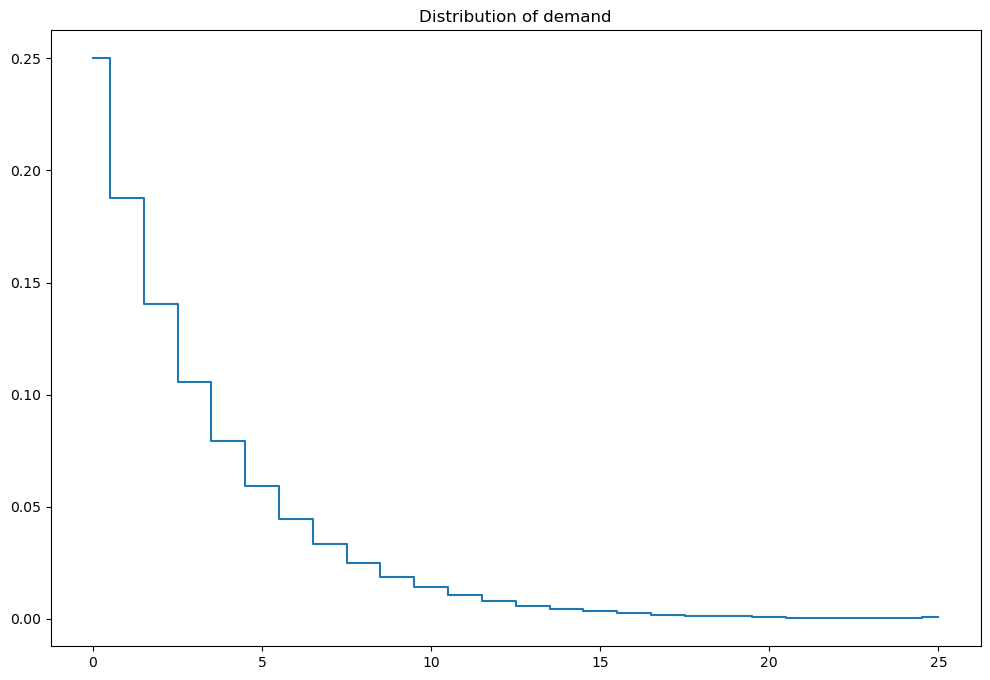

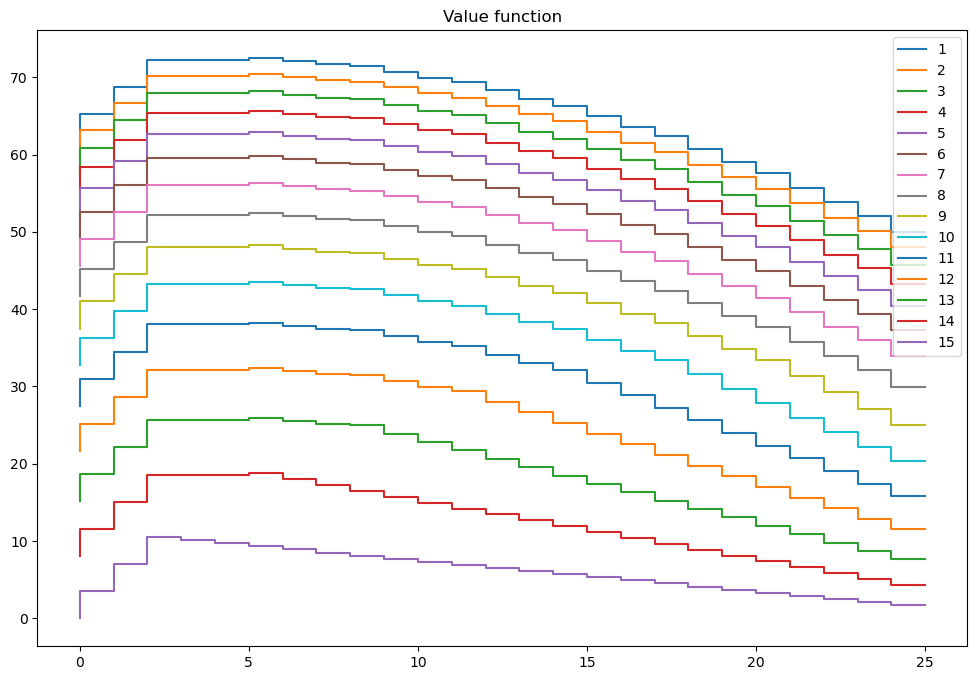

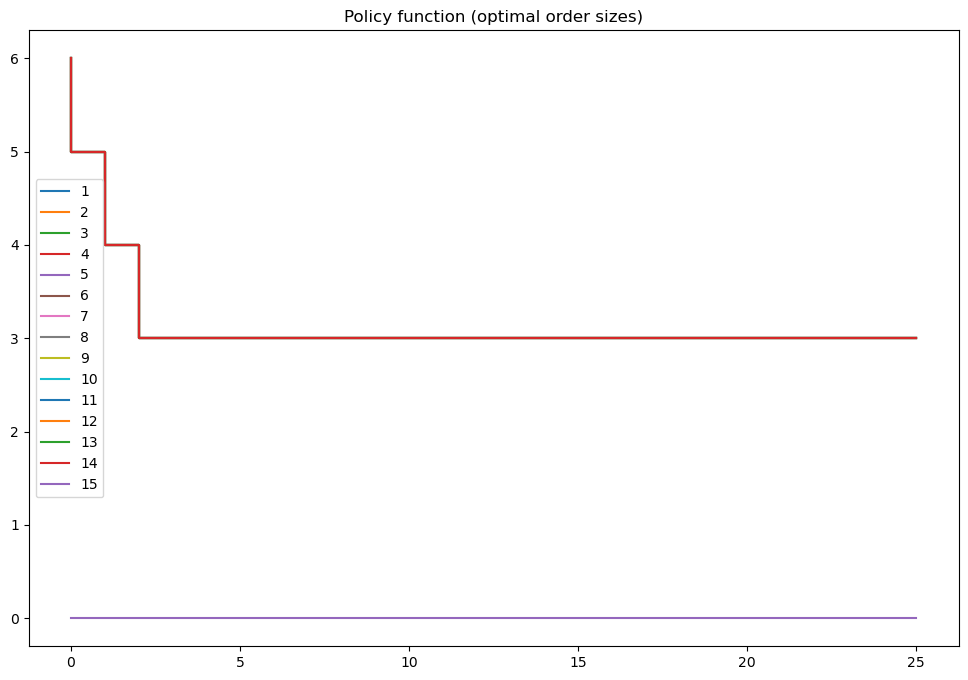

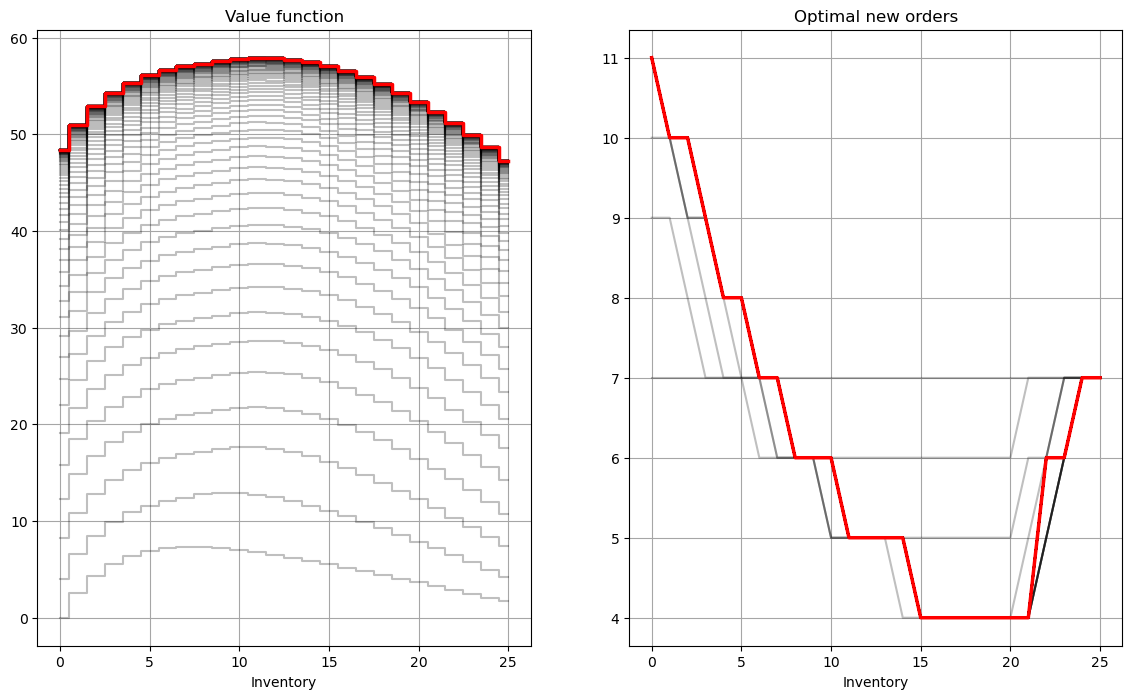

(array([48.33976371, 50.95383346, 52.87325368, 54.31261994, 55.35079428,
        56.11340794, 56.65529394, 57.05115951, 57.31191064, 57.5725757 ,
        57.81216976, 57.91500272, 57.88548623, 57.72788963, 57.44634454,
        57.04484928, 56.52727323, 55.89736092, 55.1587361 , 54.31490564,
        53.36926325, 52.3250932 , 51.18557379, 49.95378082, 48.63269084,
        47.22518442]),
 array([11, 10, 10,  9,  8,  8,  7,  7,  6,  6,  6,  5,  5,  5,  5,  4,  4,
         4,  4,  4,  4,  4,  6,  6,  7,  7]))

In [3]:
mod = inventory_model(label='production',max_inventory=25)
mod.dp=.25
mod.demand = int((1-mod.dp)/mod.dp)
mod.c = .25
mod.p = 3.5
mod.r = 0.4
mod.β = 0.9
mod.demand_pr(plot=True)
mod = solver_backwards_induction(mod,T=15)
plot_solution(mod)

solve_vfi(mod)
solve_show(mod)

In [29]:
def optimal_policy(m,ev):
    '''Computes the optimal policy function for the stochastic 
    inventory dynamics model for given EV function'''
    # idea: 3-dim array with q in axes 0, d in axis 1 and x in axis 2
    q = m.x[:,np.newaxis,np.newaxis]  # choices
    d = m.x[np.newaxis,:,np.newaxis]  # demand
    x = m.x[np.newaxis,np.newaxis,:]  # inventories
    # compute current period profit (relying on numpy broadcasting to get the matrix with choices in rows)
    p = m.profit(x,d,q)  # 3-dim array
    # indexes for next period value with extrapolation using last value
    i = np.minimum(m.next_x(x,d,q),m.upper)
    # compute the Bellman maximand
    vm = p + m.β*ev[i]
    # find argmax and argmax
    return np.argmax(vm,axis=0)  # maximum in every column

mod = inventory_model(max_inventory=15)
mod.dp=.25
mod.demand = int((1-mod.dp)/mod.dp)
mod.c = .25
mod.p = 3.5
mod.r = 0.4
mod.β = 0.9
ev,q = solve_vfi(mod)
q = optimal_policy(mod,ev)
print('Optimal orders of new inventory for d,x:\n(d in rows, x in columns)')
print(q)
# Note the symmetry in the optimal policy!
# This implies that knowing both x and d is not necessary for the
# optional new order, it's enough to condition on the inventory
# remaining after sales, i.e. x-min(x,d) = max(0,x-d)


Optimal orders of new inventory for d,x:
(d in rows, x in columns)
[[6 5 4 3 2 0 0 0 0 0 0 0 0 0 0 0]
 [6 6 5 4 3 2 0 0 0 0 0 0 0 0 0 0]
 [6 6 6 5 4 3 2 0 0 0 0 0 0 0 0 0]
 [6 6 6 6 5 4 3 2 0 0 0 0 0 0 0 0]
 [6 6 6 6 6 5 4 3 2 0 0 0 0 0 0 0]
 [6 6 6 6 6 6 5 4 3 2 0 0 0 0 0 0]
 [6 6 6 6 6 6 6 5 4 3 2 0 0 0 0 0]
 [6 6 6 6 6 6 6 6 5 4 3 2 0 0 0 0]
 [6 6 6 6 6 6 6 6 6 5 4 3 2 0 0 0]
 [6 6 6 6 6 6 6 6 6 6 5 4 3 2 0 0]
 [6 6 6 6 6 6 6 6 6 6 6 5 4 3 2 0]
 [6 6 6 6 6 6 6 6 6 6 6 6 5 4 3 2]
 [6 6 6 6 6 6 6 6 6 6 6 6 6 5 4 3]
 [6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 4]
 [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5]
 [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]]
